This notebook is largely inspired by this [other notebook](https://colab.research.google.com/drive/18EyozusBSgxa5oUBmlzXrp9fEbPyOUoC#scrollTo=_37NFK0iqCFx) originally published by IAML (Italian Association for Machine Learning).

In [1]:
# Add the codebase to the path
import sys
sys.path.insert(0,'../')

In [2]:
# Some useful imports
import numpy as np

import torch
from torch import nn, optim
from torch.utils import data

Load the Dataset

In [3]:
from pygcn.utils import load_data
symmetric_norm_flag = False

adj, features, labels, idx_train, idx_val, idx_test = load_data(path='../../pygcn/data/cora/', symm_norm=symmetric_norm_flag)

Loading cora dataset...


In [4]:
features.shape

torch.Size([2708, 1433])

In [5]:
print(labels.shape)
print(torch.max(labels))

torch.Size([2708])
tensor(6)


In [6]:
adj.shape

torch.Size([2708, 2708])

Baseline model (without any info on the graph)

In [7]:
# Feedforward Neural Network with a single hidden layer
net = nn.Sequential(nn.Linear(1433, 100), nn.ReLU(), nn.Linear(100, 7))

In [8]:
from pygcn.utils import accuracy
def test(model):
    # Test the model on the test set
    y_pred = model(features[idx_test])
    acc_test = accuracy(y_pred, labels[idx_test])
    print("Accuracy:",
              "accuracy= {:.4f}".format(acc_test.item()))

In [9]:
# Accuracy without training
test(net)

Accuracy: accuracy= 0.1460


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [11]:
import tqdm
loss_history = np.zeros(1000)

for epoch in tqdm.trange(1000):

    optimizer.zero_grad()
    outputs = net(features[idx_train])
    loss = criterion(outputs, labels[idx_train])
    loss.backward()
    optimizer.step()

    loss_history[epoch] = loss.detach().numpy()

100%|██████████| 1000/1000 [00:01<00:00, 557.19it/s]


In [12]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

In [13]:
test(net)

Accuracy: accuracy= 0.4890


Graph Convolutional Network

In [14]:
# Taken (and simplified) from:
# https://github.com/tkipf/pygcn/blob/master/pygcn/layers.py

import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight) 
        output = torch.spmm(adj, support) 
        return output + self.bias

In [15]:
#  Taken (and simplified) from:
# https://github.com/tkipf/pygcn/blob/master/pygcn/models.py

import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [16]:
gcn = GCN(1433, 50, 7)
optimizer_gcn = optim.Adam(gcn.parameters())

In [17]:
def test(model):
    y_pred = model(features, adj) # Using the whole dataset
    acc_test = accuracy(y_pred[idx_test], labels[idx_test]) # Masking on the test set
    print("Accuracy:",
              "accuracy= {:.4f}".format(acc_test.item()))

In [18]:
# Testing without training
test(gcn)

Accuracy: accuracy= 0.1390


In [19]:
import tqdm
loss_history = np.zeros(2500) 

for epoch in tqdm.trange(2500): 
  
    optimizer_gcn.zero_grad()
    outputs = gcn(features, adj) # Usiamo tutto il dataset
    loss = criterion(outputs[idx_train], labels[idx_train]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn.step()

    loss_history[epoch] = loss.detach().numpy()

100%|██████████| 2500/2500 [00:26<00:00, 96.07it/s]


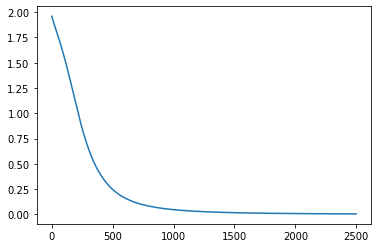

In [20]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

In [21]:
test(gcn)

Accuracy: accuracy= 0.7930


In [22]:
# Snippet taken from: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
net_params = sum(p.numel() for p in net.parameters() if p.requires_grad) 
gcn_params = sum(p.numel() for p in gcn.parameters() if p.requires_grad)

print('First model parameters: ', net_params)
print('Second model parameters: ', gcn_params)

First model parameters:  144107
Second model parameters:  72057


What if... we make use of the $D^{-\frac{1}{2}} A  D^{-\frac{1}{2}}$ normalization formula?

In [23]:
from pygcn.utils import load_data
symmetric_norm_flag = True # change this flag to enable the D^-1/2 A D^-1/2 formula

adj, features, labels, idx_train, idx_val, idx_test = load_data(path='../../pygcn/data/cora/', symm_norm=symmetric_norm_flag)

Loading cora dataset...


In [24]:
gcn = GCN(1433, 50, 7)
optimizer_gcn = optim.Adam(gcn.parameters())

In [25]:
# Testing without training
test(gcn)

Accuracy: accuracy= 0.1590


In [26]:
import tqdm
loss_history = np.zeros(5000) 

for epoch in tqdm.trange(5000): 
  
    optimizer_gcn.zero_grad()
    outputs = gcn(features, adj) # Usiamo tutto il dataset
    loss = criterion(outputs[idx_train], labels[idx_train]) # Mascheriamo sulla parte di training
    loss.backward()
    optimizer_gcn.step()

    loss_history[epoch] = loss.detach().numpy()

100%|██████████| 5000/5000 [00:47<00:00, 104.21it/s]


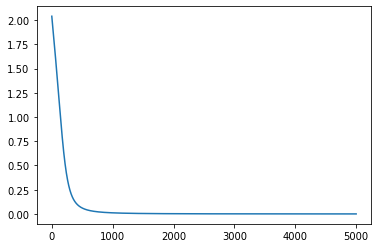

In [27]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

In [28]:
test(gcn)

Accuracy: accuracy= 0.6160


In [29]:
# Snippet taken from: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
net_params = sum(p.numel() for p in net.parameters() if p.requires_grad) 
gcn_params = sum(p.numel() for p in gcn.parameters() if p.requires_grad)

print('First model parameters: ', net_params)
print('Second model parameters: ', gcn_params)

First model parameters:  144107
Second model parameters:  72057
